In [23]:
from tqdm import tqdm
%matplotlib inline
import re

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import (
    wordnet,
    stopwords
)

#import libraries for tokenization and ML
import json;
import keras;
import keras.preprocessing.text as kpt;
#from keras.preprocessing.text import Tokenizer;

import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from keras.models import (
    Sequential,
    model_from_json
)
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from keras.layers import Dense, Dropout, Activation;


In [24]:
table = pd.read_csv("/Users/ilmasheriff/tweetdata",encoding= 'unicode_escape')

In [4]:
table.shape

(1010508, 5)

In [5]:
table.head()

,Unnamed: 0,Data,Subjectivity,Polarity,Score
0,0,cnsnews benshapiro Can COVID19Vaccine end the ...,0.0,0.0,Neutral
1,1,IntrepidWarrior realDonaldTrump Can COVID19Vac...,0.0,0.0,Neutral
2,2,edyong209 HelenBranswell Can COVID19Vaccine en...,0.0,0.0,Neutral
3,3,AdamTexDavis Can COVID19Vaccine end the pandemic,0.0,0.0,Neutral
4,4,HegKong Can COVID19Vaccine end the pandemic,0.0,0.0,Neutral


In [5]:
table.Score.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [6]:
table

,Unnamed: 0,Data,Subjectivity,Polarity,Score
0,0,cnsnews benshapiro Can COVID19Vaccine end the ...,0.000000,0.000000,Neutral
1,1,IntrepidWarrior realDonaldTrump Can COVID19Vac...,0.000000,0.000000,Neutral
2,2,edyong209 HelenBranswell Can COVID19Vaccine en...,0.000000,0.000000,Neutral
3,3,AdamTexDavis Can COVID19Vaccine end the pandemic,0.000000,0.000000,Neutral
4,4,HegKong Can COVID19Vaccine end the pandemic,0.000000,0.000000,Neutral
...,...,...,...,...,...
899995,899995,BarackObama The whole is literally sat down li...,0.344444,0.022222,Positive
899996,899996,I dont know about you but I want this pandemic...,0.000000,0.000000,Neutral
899997,899997,RT CedarsSinai Experts are doing everything th...,0.000000,0.000000,Neutral
899998,899998,US disease expert Fauci says vaccine verdict d...,0.337500,-0.012500,Negative


In [25]:
def getTextAnalysis(a):
    if a > 0:
        return "1"
    else:
        return "0"

In [26]:
table['Score'] = table['Polarity'].apply(getTextAnalysis)

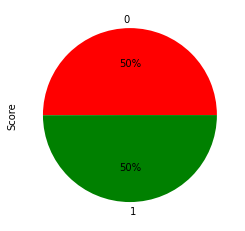

In [27]:
table.Score.value_counts().plot(kind='pie', autopct='%2.0f%%', colors=["red","green"])

In [28]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['Data'] = table['Data'].str.lower()
    #Replace rt indicating that was a retweet
    table['Data'] = table['Data'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['Data'] = table['Data'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['Data'] = table['Data'].replace(r'http\S+', '', regex=True)
    table['Data'] = table['Data'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['Data'] = table['Data'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['Data'] = table['Data'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return table

In [29]:
# Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word):
            row = re.sub(word, replace_elongated_word(word), row)
    return row


In [30]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['Data'] = table['Data'].str.lower()
    table['Data'] = table['Data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table


In [31]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)


In [32]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['Data'] = table['Data'].apply(lambda x: detect_elongated_words(x))
    table['Data'] = table['Data'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

In [33]:
#Vectorization for Data Visualization
def vectorization(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.Data)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    frequency_df = pd.DataFrame([frequency], columns=vector.get_feature_names()).transpose()
    return frequency_df

In [34]:
def word_cloud(tweets):
    
    #We get the directory that we are working on
    file = os.getcwd()

    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000,  contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=["covid19"])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()


In [35]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

In [36]:
def regression_graph(table):
    table = table[1:]
    #We set the style of seaborn
    sns.set_style("whitegrid")   
    #Initialize the figure
    plt.figure(figsize=(6,6))
    
    #we obtain the points from matplotlib scatter
    points = plt.scatter(table["1"], table["0"], c=table["1"], s=75, cmap="bwr")
    #graph the colorbar
    plt.colorbar(points)
    #we graph the regplot from seaborn
    sns.regplot(x="1", y="0",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

In [37]:
# Split Data into training and test dataset
def splitting(table):
    X_train, X_test, y_train, y_test = train_test_split(table.Data, table.Score, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test


In [38]:
#Tokenization for analysis
def tokenization_tweets(dataset, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

In [39]:
def test(X_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

In [40]:
tweet_table = cleaning_table(table)

In [41]:
tweet_table[tweet_table['Score'] == "0"]["Data"]

0              cnsnews benshapiro covidvacine end pandemic
1        intrepidwarior realdonaldtrump covidvacine end...
2            edyong helenbranswel covidvacine end pandemic
3                    adamtexdavis covidvacine end pandemic
4                         hegkong covidvacine end pandemic
                               ...                        
89991    covidvacine indian company bharatbiotech along...
89994    amrefworldwide save date join us panership w p...
89995    healthcareldr astrazeneca says coronavirusvaci...
89997    astrazeneca says coronavirusvacine vaccine tri...
89999    thetribunechd oxford covidvacine trials produc...
Name: Data, Length: 45024, dtype: object

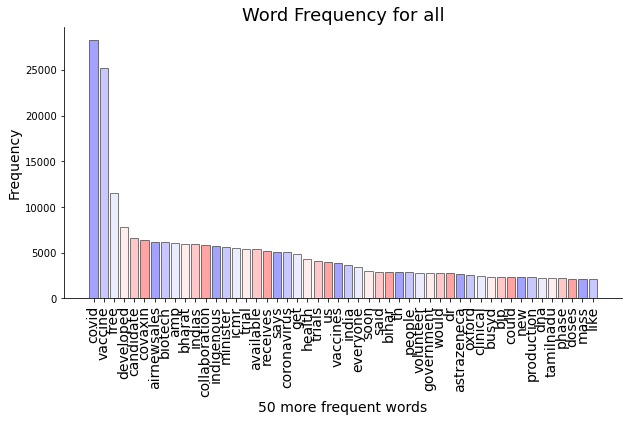

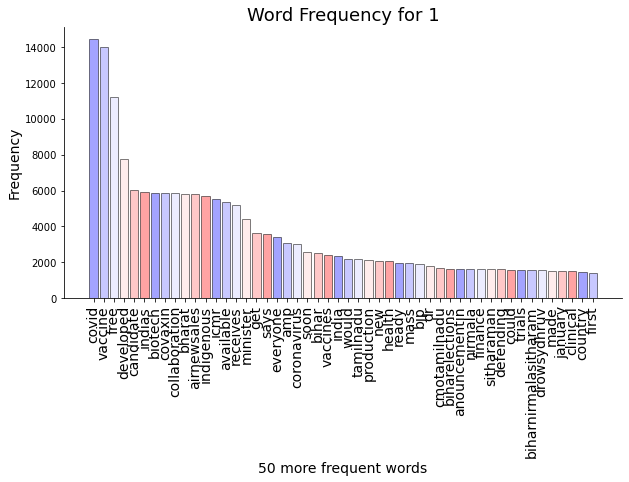

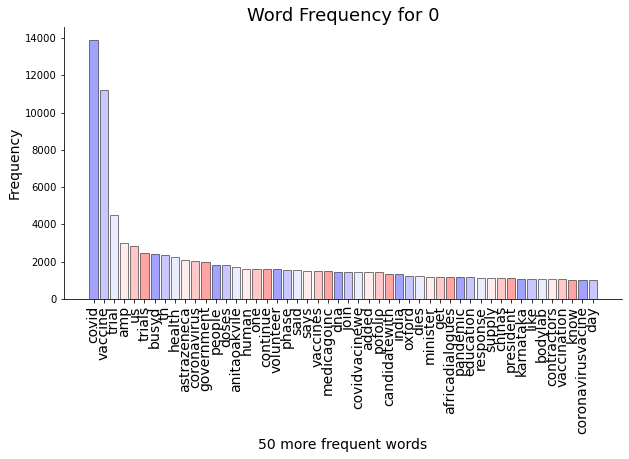

In [42]:
if __name__ == "__main__":
    #Get the frequency
    word_frequency = vectorization(tweet_table).sort_values(0, ascending = False)
    word_frequency_pos = vectorization(tweet_table[tweet_table['Score'] == '1']).sort_values(0, ascending = False)
    word_frequency_neg = vectorization(tweet_table[tweet_table['Score'] == '0']).sort_values(0, ascending = False)

    #Graph with frequency words all, positive and negative tweets and get the frequency
    graph(word_frequency, 'all')
    graph(word_frequency_pos, '1')
    graph(word_frequency_neg, '0')


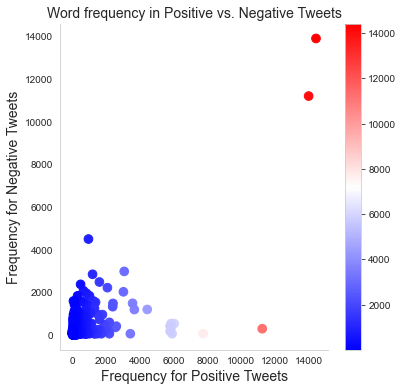

In [43]:
if __name__ == "__main__":
    #Concatenate word frequency for positive and negative
    table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
    table_regression.columns = ["1", "0"]
    regression_graph(table_regression)



In [44]:
if __name__ == "__main__":
    tweet_table = table

In [45]:
if __name__ == "__main__":
    tweet_table['Score'] = tweet_table['Score'].apply(lambda x: 2 if x == '2' else (0 if x == '1' else 1))

In [46]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = splitting(tweet_table)

In [54]:
#Create a Neural Network
#Create the model
def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, layer3,layer4,layer5, layer6, layer7,epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer3, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer4, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer5, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer6, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer7, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
#     , 'precision','recall','auc'
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=shuffle)
    return model_nn

In [48]:
def model1(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 600
    layer2 = 512
    layer3 = 256
    layer4 = 200
    layer5 = 112
    layer6 = 56
    layer7 = 16
    epoch = 10
    lr = 0.002
    epsilon = 0.00008
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4,layer5, layer6, layer7, epoch, lr, epsilon, validation)
    return model;
model1(X_train, y_train)

Epoch 1/10
2025/2025 [==============================] - 77s 38ms/step - loss: 0.7553 - accuracy: 0.3043 - val_loss: 0.7504 - val_accuracy: 0.4976
Epoch 2/10
2025/2025 [==============================] - 66s 33ms/step - loss: 0.7532 - accuracy: 0.2920 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 3/10
2025/2025 [==============================] - 64s 32ms/step - loss: 0.7532 - accuracy: 0.2990 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 4/10
2025/2025 [==============================] - 63s 31ms/step - loss: 0.7532 - accuracy: 0.3087 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 5/10
2025/2025 [==============================] - 74s 36ms/step - loss: 0.7532 - accuracy: 0.3161 - val_loss: 0.7504 - val_accuracy: 0.5024
Epoch 6/10
2025/2025 [==============================] - 67s 33ms/step - loss: 0.7532 - accuracy: 0.3261 - val_loss: 0.7504 - val_accuracy: 0.4976
Epoch 7/10
2025/2025 [==============================] - 64s 32ms/step - loss: 0.7532 - accuracy: 0.3238 - val_lo

In [52]:
def model2(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 600
    layer2 = 512
    layer3 = 256
    layer4 = 200
    epoch = 5
    lr = 0.002
    epsilon = 0.00000001
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4, epoch, lr, epsilon, validation)
    return model;
model2(X_train, y_train)

Epoch 1/5
2025/2025 [==============================] - 68s 34ms/step - loss: 0.7544 - accuracy: 0.3497 - val_loss: 0.7504 - val_accuracy: 0.4976
Epoch 2/5
2025/2025 [==============================] - 57s 28ms/step - loss: 0.7532 - accuracy: 0.3500 - val_loss: 0.7504 - val_accuracy: 0.5024
Epoch 3/5
2025/2025 [==============================] - 53s 26ms/step - loss: 0.7532 - accuracy: 0.3541 - val_loss: 0.7504 - val_accuracy: 0.4976
Epoch 4/5
2025/2025 [==============================] - 59s 29ms/step - loss: 0.7532 - accuracy: 0.3470 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 5/5
2025/2025 [==============================] - 61s 30ms/step - loss: 0.7532 - accuracy: 0.3488 - val_loss: 0.7504 - val_accuracy: 0.0000e+00


In [53]:
def model3(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 600
    layer2 = 512
    layer3 = 256
    layer4 = 200
    epoch = 5
    lr = 0.009
    epsilon = 0.001
    validation = 0.2
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4, epoch, lr, epsilon, validation)
    return model;
model3(X_train, y_train)

Epoch 1/5
1800/1800 [==============================] - 66s 37ms/step - loss: 0.7546 - accuracy: 0.3462 - val_loss: 0.7554 - val_accuracy: 0.0000e+00
Epoch 2/5
1800/1800 [==============================] - 62s 35ms/step - loss: 0.7523 - accuracy: 0.3534 - val_loss: 0.7554 - val_accuracy: 0.4952
Epoch 3/5
1800/1800 [==============================] - 46s 26ms/step - loss: 0.7523 - accuracy: 0.3561 - val_loss: 0.7554 - val_accuracy: 0.0000e+00
Epoch 4/5
1800/1800 [==============================] - 50s 28ms/step - loss: 0.7523 - accuracy: 0.3546 - val_loss: 0.7554 - val_accuracy: 0.4952
Epoch 5/5
1800/1800 [==============================] - 53s 29ms/step - loss: 0.7523 - accuracy: 0.3580 - val_loss: 0.7554 - val_accuracy: 0.4952


In [56]:
def model4(X_train, y_train):   
    features = 3000
    shuffle = True
    drop = 0.5
    layer1 = 540
    layer2 = 532
    layer3 = 256
    layer4 = 230
    layer5 = 112
    layer6 = 56
    layer7 = 10
    epoch = 5
    lr = 0.002
    epsilon = 0.00000001
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2,layer3, layer4,layer5,layer6, layer7, epoch, lr, epsilon, validation)
    return model;
model4(X_train, y_train)

Epoch 1/5
2025/2025 [==============================] - 60s 30ms/step - loss: 0.7546 - accuracy: 0.2000 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 2/5
2025/2025 [==============================] - 65s 32ms/step - loss: 0.7532 - accuracy: 0.1792 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 3/5
2025/2025 [==============================] - 59s 29ms/step - loss: 0.7532 - accuracy: 0.1856 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 4/5
2025/2025 [==============================] - 59s 29ms/step - loss: 0.7532 - accuracy: 0.2210 - val_loss: 0.7504 - val_accuracy: 0.0000e+00
Epoch 5/5
2025/2025 [==============================] - 64s 31ms/step - loss: 0.7532 - accuracy: 0.2708 - val_loss: 0.7504 - val_accuracy: 0.4976
